In [37]:
import numpy as np
import os

from type_definitions.test_case import TestCase
from type_definitions.test_result import TestResult
from type_definitions.utils import *
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [38]:
seed = 100
save_plot = False
use_cached_distance_matrix = True
n_components = 5  # Number of GMM components

In [39]:
np.random.seed(seed)

cases = generate_cases(80)
results = evaluate_cases(cases)
trajectories = [r.trajectory for r in results if not r.simulation_failed]
valid_results = [r for r in results if not r.simulation_failed]
print(f"Generated {len(trajectories)} valid trajectories")
print(
    f"Crashed: {sum(1 for r in valid_results if r.crashed)}, Safe: {sum(1 for r in valid_results if not r.crashed)}"
)

Generated 38 valid trajectories
Crashed: 16, Safe: 22


In [40]:
os.makedirs("cache", exist_ok=True)
distance_matrix_file = f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"

if use_cached_distance_matrix and os.path.exists(distance_matrix_file):
    print(f"Loading distance matrix from {distance_matrix_file}")
    distance_matrix = np.load(distance_matrix_file)
else:
    print("Calculating pairwise distances...")
    distance_matrix = pairwise_distances(trajectories)
    np.save(distance_matrix_file, distance_matrix)
    print(f"Distance matrix saved to {distance_matrix_file}")

print(f"Distance matrix shape: {distance_matrix.shape}")

Loading distance matrix from cache/distance_matrix_seed100_size38.npy
Distance matrix shape: (38, 38)


In [41]:
# Apply MDS to convert distance matrix to feature space
print("Applying MDS transformation...")
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=seed)
X_transformed = mds.fit_transform(distance_matrix)
print(f"MDS transformed features shape: {X_transformed.shape}")
print(f"MDS stress: {mds.stress_:.4f}")

Applying MDS transformation...
MDS transformed features shape: (38, 3)
MDS stress: 15774633.6535


/Users/y65ng/Developer/unc/research/code/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [42]:
# Apply GMM clustering with n=5 components
print(f"Applying GMM clustering with {n_components} components...")
gmm = GaussianMixture(n_components=n_components, random_state=seed)
gmm.fit(X_transformed)

# Get BIC and AIC scores
bic = gmm.bic(X_transformed)
aic = gmm.aic(X_transformed)
print(f"BIC: {bic:.2f}, AIC: {aic:.2f}")

# Apply clustering
clusters = gmm.predict(X_transformed)
cluster_probs = gmm.predict_proba(X_transformed)
unique_clusters = np.unique(clusters)

Applying GMM clustering with 5 components...
BIC: 2096.93, AIC: 2016.69


In [43]:
# Calculate cluster statistics
print("GMM Cluster statistics:")
for cluster_id in unique_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = len(cluster_results)
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    print(
        f"    Cluster {cluster_id}: {crashed_in_cluster}/{total_in_cluster} crashed ({crash_rate:.2f}%)"
    )

GMM Cluster statistics:
    Cluster 0: 9/12 crashed (75.00%)
    Cluster 1: 0/5 crashed (0.00%)
    Cluster 2: 0/8 crashed (0.00%)
    Cluster 3: 7/11 crashed (63.64%)
    Cluster 4: 0/2 crashed (0.00%)


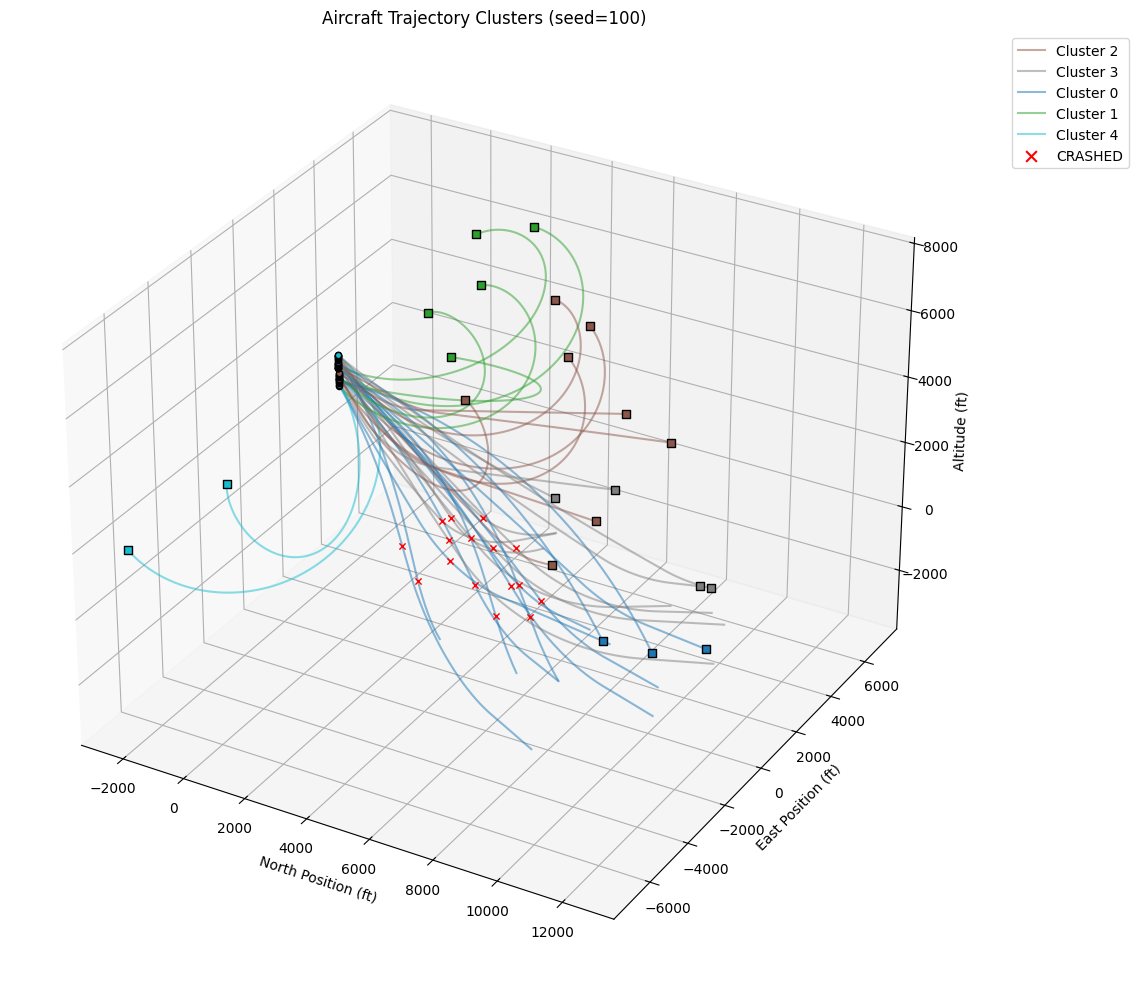

In [44]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

plotted_clusters = set()

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    color = colors[cluster_id % len(colors)]
    if cluster_id not in plotted_clusters:
        label = f"Cluster {cluster_id}"
        plotted_clusters.add(cluster_id)
    else:
        label = None

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )
    else:
        # Safe landing point
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

# Add legend for crashed trajectories
if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

# Add legend for unsafe g-forces
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(
        f"results/gmm_{n_components}_clusters_3d.png", dpi=300, bbox_inches="tight"
    )
    print(f"Plot saved to results/gmm_{n_components}_clusters_3d.png")

plt.show()

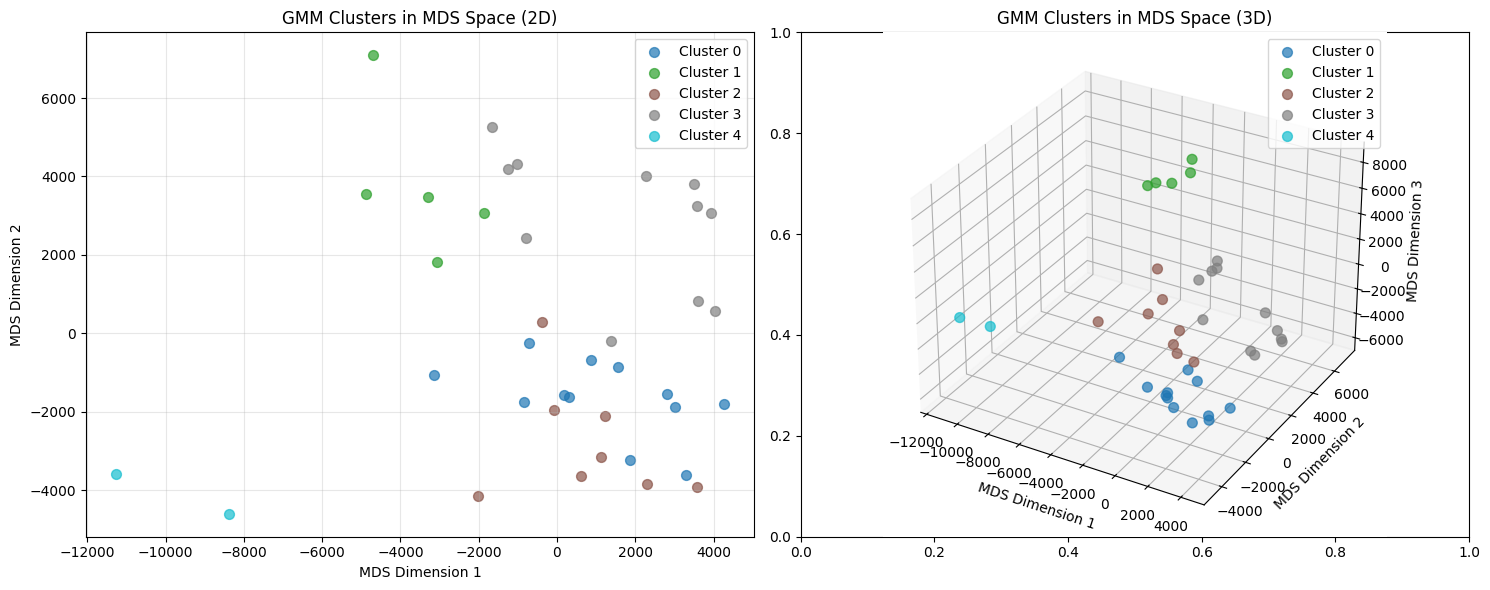

In [45]:
# Visualize clusters in MDS space
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 2D projection of MDS space
colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

for cluster_id in unique_clusters:
    mask = clusters == cluster_id
    color = colors[cluster_id % len(colors)]

    # Plot first two MDS dimensions
    ax1.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
        c=[color],
        label=f"Cluster {cluster_id}",
        alpha=0.7,
        s=50,
    )

ax1.set_xlabel("MDS Dimension 1")
ax1.set_ylabel("MDS Dimension 2")
ax1.set_title("GMM Clusters in MDS Space (2D)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 3D visualization of MDS space
ax2 = fig.add_subplot(122, projection="3d")

for cluster_id in unique_clusters:
    mask = clusters == cluster_id
    color = colors[cluster_id % len(colors)]

    ax2.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
        X_transformed[mask, 2],
        c=[color],
        label=f"Cluster {cluster_id}",
        alpha=0.7,
        s=50,
    )

ax2.set_xlabel("MDS Dimension 1")
ax2.set_ylabel("MDS Dimension 2")
ax2.set_zlabel("MDS Dimension 3")
ax2.set_title("GMM Clusters in MDS Space (3D)")
ax2.legend()

plt.tight_layout()

if save_plot:
    plt.savefig(
        f"results/gmm_{n_components}_clusters_mds.png",
        dpi=300,
        bbox_inches="tight",
    )
    print(f"MDS plot saved to results/gmm_{n_components}_clusters_mds.png")

plt.show()